# Neural Style Transfer

We'll attempt to generate an image that matches the content of one input image and the content of another input image. We'll acomplish this by balancing the content loss and the style loss simultaneously

In [7]:
from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from skimage.transform import resize

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import fmin_l_bfgs_b

from style_transfer1 import VGG16_AvgPool, VGG16_AvgPool_CutOff, unpreprocess, scale_img
from style_transfer2 import gram_matrix, style_loss, minimize

In [9]:
STYLE = 'KlimtKiss.jpg'
CONTENT = 'kissTIME.jpg'
 
# load the content image
def load_img_and_preprocess(path, shape=None):
  img = image.load_img(path, target_size=shape)

  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  return x

content_img = load_img_and_preprocess(CONTENT)

# resize the style image
h, w = content_img.shape[1:3]
style_img = load_img_and_preprocess(STYLE,(h, w))

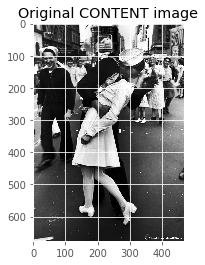

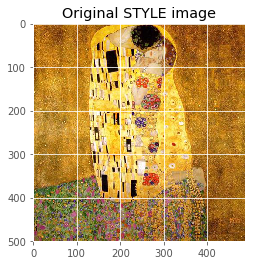

In [10]:
# plot the original images
path1 = CONTENT
img1 = image.load_img(path1)
content_orig = image.img_to_array(img1)

path2 = STYLE    
img2 = image.load_img(path2)
style_orig = image.img_to_array(img2)

def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x

plt.imshow(scale_img(content_orig))
plt.title('Original CONTENT image')
plt.show()

plt.imshow(scale_img(style_orig))
plt.title('Original STYLE image')
plt.show()

In [11]:
import warnings
warnings.filterwarnings("ignore")

batch_shape = content_img.shape
shape = content_img.shape[1:]
vgg = VGG16_AvgPool(shape)
vgg.summary()
content_model = Model(vgg.input, vgg.layers[13].get_output_at(0)) # changed 1 to 0 because error
content_target = K.variable(content_model.predict(content_img))

# create the style model
symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in vgg.layers \
  if layer.name.endswith('conv1')
]

# make a big model that outputs multiple layers' outputs
style_model = Model(vgg.input, symbolic_conv_outputs)

# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

# we will assume the weight of the content loss is 1
# and only weight the style losses
#style_weights = [0.2,0.4,0.3,0.5,0.2]
style_weights = [0.02,0.1,0.03,0.1,0.2]

# create the total loss which is the sum of content + style loss
loss = K.mean(K.square(content_model.output - content_target))

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
  # gram_matrix() expects a (H, W, C) as input
  loss += w * style_loss(symbolic[0], actual[0]) # w represents the style weight

# they are both pointing to the same keras Input layer in memory
grads = K.gradients(loss, vgg.input)

# just like theano.function
get_loss_and_grads = K.function(
  inputs=[vgg.input],
  outputs=[loss] + grads
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 676, 468, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 676, 468, 64)      36928     
_________________________________________________________________
average_pooling2d_6 (Average (None, 338, 234, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 338, 234, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 338, 234, 128)     147584    
_________________________________________________________________
average_pooling2d_7 (Average (None, 169, 117, 128)     0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 169, 117, 256)     295168    
__________



Infusing CONTENT with STYLE...

epoch=0, loss=611.0906372070312, epoch duration = 0:01:01.321332, total min = 1.022
epoch=1, loss=232.60055541992188, epoch duration = 0:01:52.689484, total min = 1.878
epoch=2, loss=166.48048400878906, epoch duration = 0:02:44.307577, total min = 2.738
epoch=3, loss=140.692138671875, epoch duration = 0:03:35.981472, total min = 3.600
epoch=4, loss=125.92240142822266, epoch duration = 0:04:28.257412, total min = 4.471
epoch=5, loss=116.61650848388672, epoch duration = 0:05:19.606306, total min = 5.327
epoch=6, loss=108.79533386230469, epoch duration = 0:06:12.267264, total min = 6.204
epoch=7, loss=103.26589965820312, epoch duration = 0:07:03.755831, total min = 7.063
epoch=8, loss=98.66925811767578, epoch duration = 0:07:55.331103, total min = 7.922
epoch=9, loss=95.37718200683594, epoch duration = 0:08:47.683561, total min = 8.795

Total duration: 49.020 min


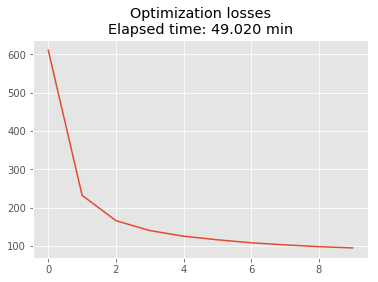

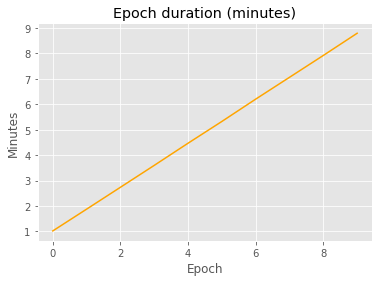

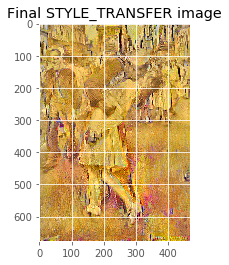

In [12]:
def get_loss_and_grads_wrapper(x_vec):
  l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
  return l.astype(np.float64), g.flatten().astype(np.float64)


final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale_img(final_img))
plt.title('Final STYLE_TRANSFER image')
plt.show()